
# Handle Missing Values

In [1]:
# import packages

# data processing
import pandas as pd
import numpy as np
from datetime import timedelta, datetime


import re

# data visualization
import plotly.graph_objs as go
from plotly.graph_objs import Bar, Layout
from plotly import offline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

# change text color
import colorama
from colorama import Fore, Style

# IPython
from IPython.display import IFrame

In [2]:
test = pd.read_csv('F:/BaiduNetdiskDownload/WhaleDataScienceProject-master/test.csv')
train = pd.read_csv('F:/BaiduNetdiskDownload/WhaleDataScienceProject-master/train.csv')

In [3]:
 fullset = pd.concat([train,test],ignore_index=True)

## Missing Value diagnosis

### Metadata

In [4]:
def meta(train,test,missing_values = -1,cols_ignore_missing = []):
    
    df = pd.concat([train,test]).reset_index(drop=True).fillna('未知')
    data = []
    for col in df.columns:
        # def role
        if col == 'target':
            role = 'target'
        elif col == 'id':
            role = 'id'
        else:
            role = 'feature'
        
        # def category
        if 'ind' in col:
            category = 'individual'
        elif 'car' in col:
            category = 'car'
        elif 'calc' in col:
            category = 'calculated'
        elif 'reg' in col:
            category = 'region'
        else:
            category = 'other'
        
        
        # def level of measurements
        if 'bin' in col or col == 'target':
            level = 'binary'
        elif 'cat' in col[-3:] or col == 'id':
            level = 'nominal'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() > 1:
            level = 'interval'
        elif df[col].dtype == 'float64' and df[col].replace(missing_values,np.nan).max()-df[col].replace(missing_values,np.nan).min() <= 1:
            level = 'ratio'
        elif df[col].dtype == 'int64':
            level = 'ordinal'
            
        # def data type
        dtype = df[col].dtype
        
        # def unique
        if col == 'id' or df[col].dtype == 'float64':
            uniq = 'Ignore'
        else:
            if col in cols_ignore_missing:
                uniq = df[col].nunique()
            else:
                uniq = df[col].replace({missing_values:np.nan}).nunique()
                
        # def cardinality
        if uniq == 'Ignore':
            cardinality = 'Ignore'
        elif uniq <= 10:
            cardinality = 'Low Cardinality'
        elif uniq <= 30:
            cardinality = 'Medium Cardinality'
        else:
            cardinality = 'High Cardinality'
        
        # def missing
        if col in cols_ignore_missing:
            missing = 0
        else:
            missing = sum(df[col] == missing_values)
            
        # def missing percent
        missing_percent = f'{missing}({round(missing*100/len(df),2)}%)'
        
        # def imputation
        if missing > df.shape[0]*0.4:
            imputation = 'remove'
        elif missing > 0:
            if level == 'binary' or level == 'nominal':
                imputation = ('mode')
            if level == 'ordinal':
                imputation = ('mode','median')
            if level == 'interval' or level == 'ratio':
                imputation = ('mode','median','mean')        
        else:
            imputation = "No Missing"
            
        # def keep
        keep = True
        if col  == 'id' or imputation == 'remove':
            keep = False
        col_dict = {
            'colname': col,
            'role': role,
            'category': category,
            'level': level,
            'dtype': dtype,
            'cardinality': uniq,
            'cardinality_level':cardinality,
            'missing': missing,
            'missing_percent': missing_percent,
            'imputation':imputation,
            'keep': keep,
        }
        data.append(col_dict)
    meta = pd.DataFrame(data, columns=list(col_dict.keys()))
    meta.set_index('colname', inplace=True)
    
    return meta

In [5]:
metadata = meta(train,test)

In [6]:
missing_data = metadata[['missing','missing_percent','imputation']][metadata['missing']>0].sort_values(by = 'missing',ascending=False)

In [7]:
missing_data

,missing,missing_percent,imputation
colname,,,
ps_car_03_cat,1028142,1028142(69.09%),remove
ps_car_05_cat,666910,666910(44.82%),remove
ps_reg_03,269456,269456(18.11%),"(mode, median, mean)"
ps_car_14,106425,106425(7.15%),"(mode, median, mean)"
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode


In [8]:
cols_to_drop = missing_data[missing_data.imputation == 'remove'].index.to_list()

In [9]:
cols_to_imp = missing_data.index[2:].to_list()
cols_to_imp_3m = missing_data[missing_data.imputation == ('mode', 'median', 'mean')].index.to_list()
cols_to_imp_2m = missing_data[missing_data.imputation == ('mode', 'median')].index.to_list()
cols_to_imp_1m = missing_data[missing_data.imputation == ('mode')].index.to_list()

### Using missingno

In [10]:
import missingno as msno

<AxesSubplot:>

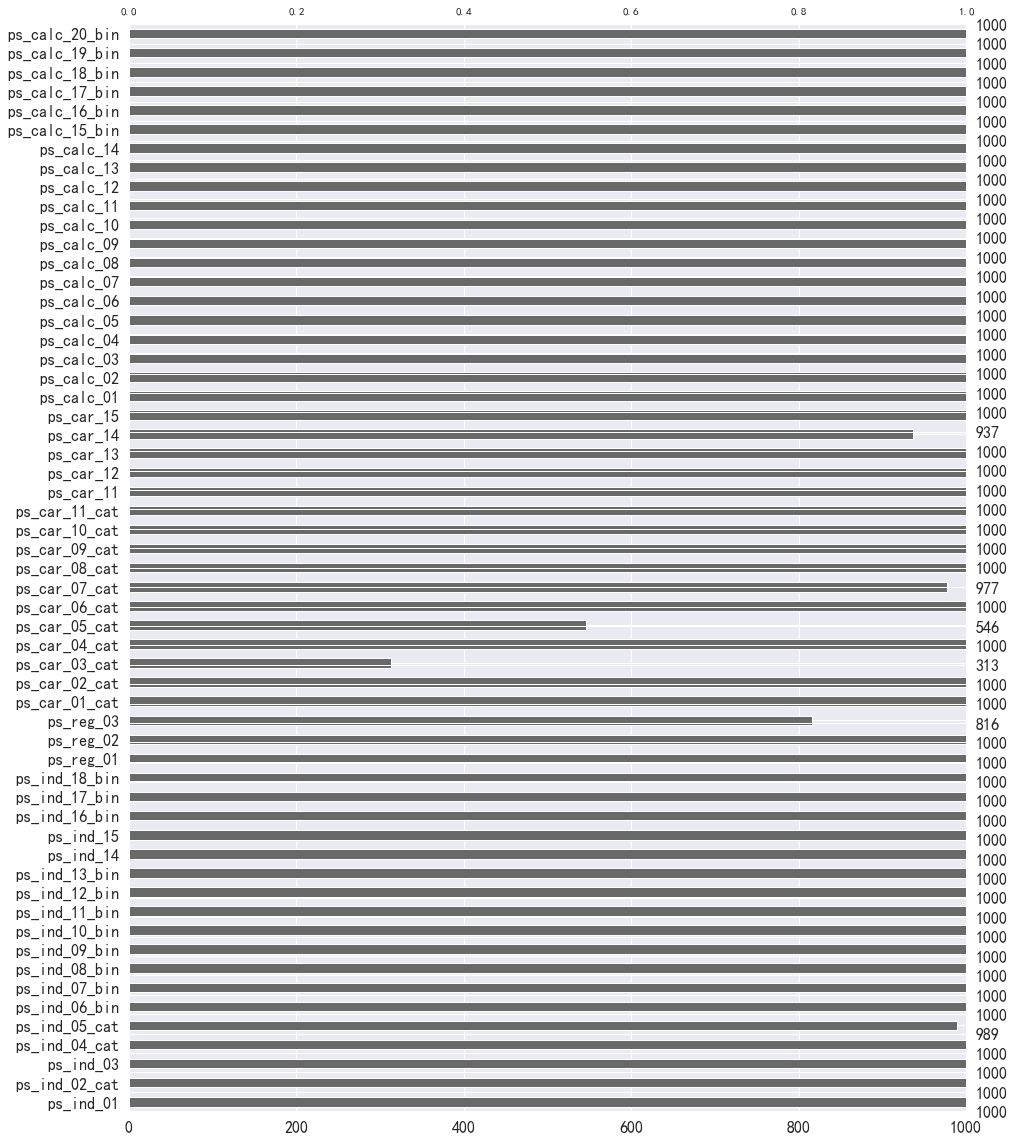

In [11]:
msno.bar(fullset.drop(['id','target'],axis=1).replace(-1,np.nan).sample(1000),figsize = [15,20]) 

<AxesSubplot:>

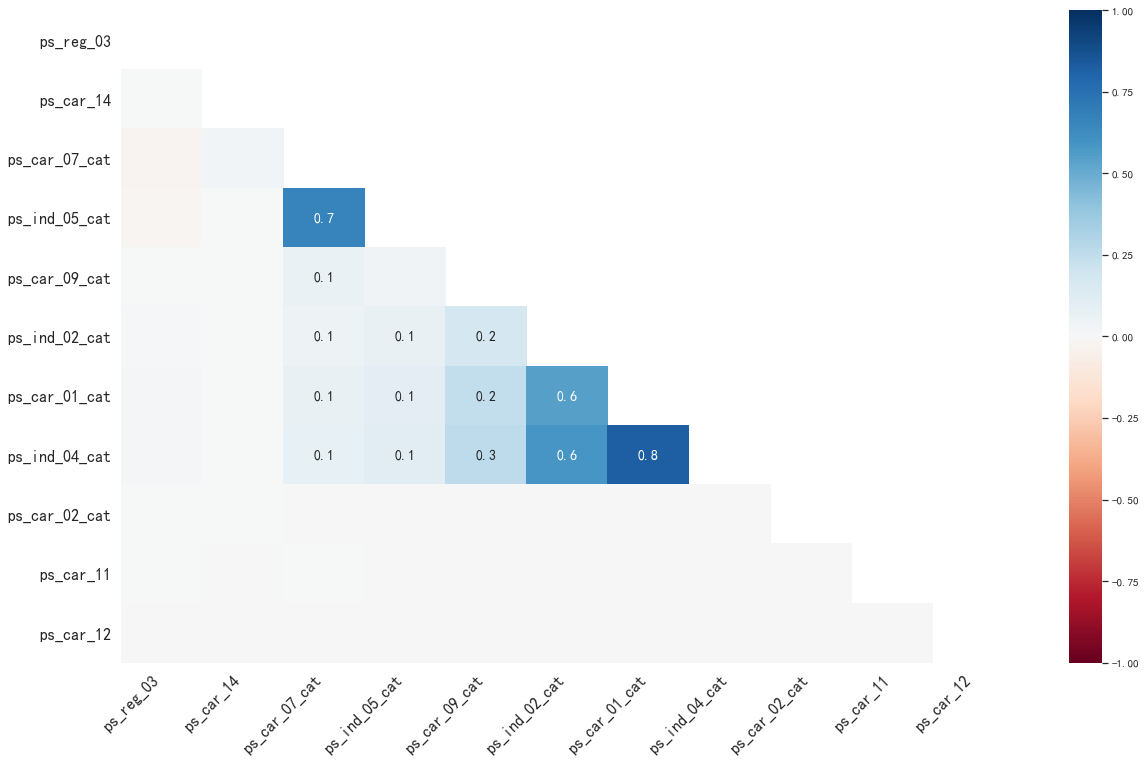

In [12]:
msno.heatmap(fullset[cols_to_imp].replace(-1,np.nan))

<AxesSubplot:>

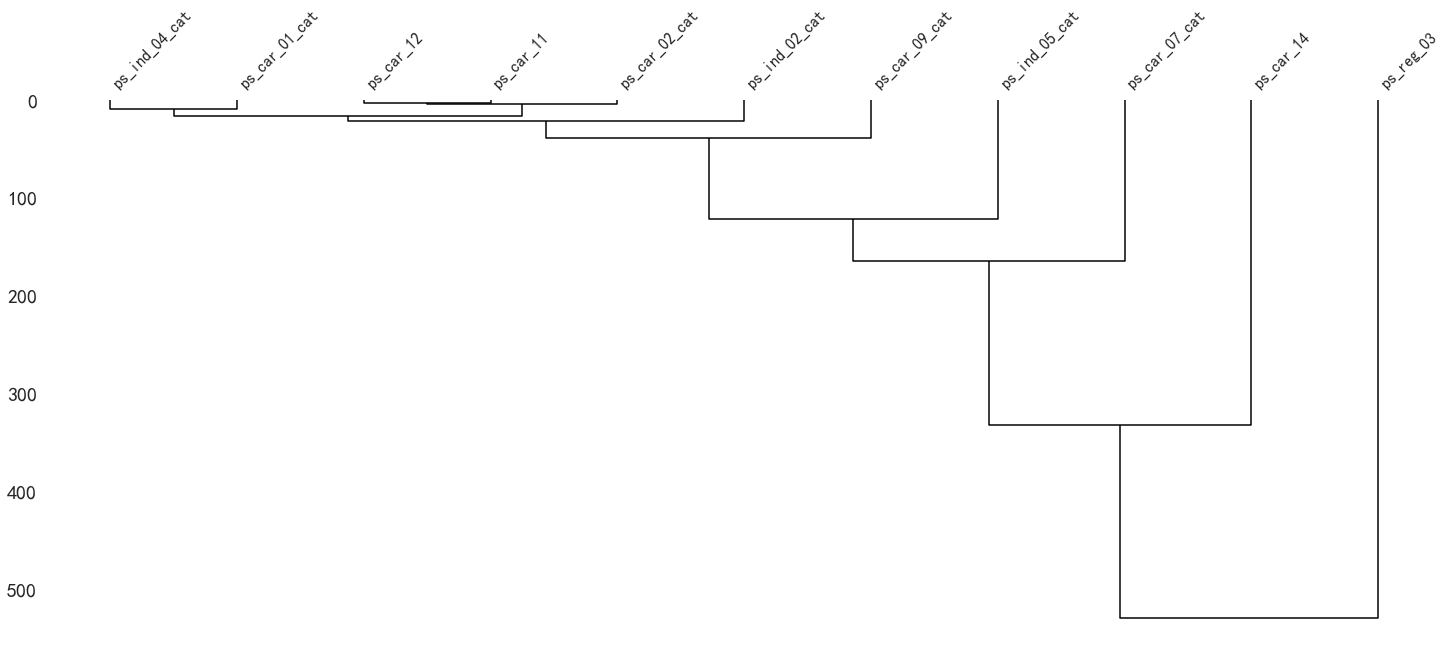

In [13]:
msno.dendrogram(fullset[cols_to_imp].replace(-1,np.nan))

### Multivariate filling

From the above figure, we can see the degree of missing value correlation between each pair of variables, such as:

The absence of ps_car_01_cat will lead to the absence of ps_ind_04_cat, which is a positive relationship, and the degree of correlation is very large!

So, next, I will introduce [multivariable filling], if the reason for the generation of missing values ​​between variables is related (heatmap above)

As can be seen from the figure above, we try to use the multivariate filling method to fill the associated variables!

- ps_ind_05_cat | ps_car_07_cat
- ps_car_01_cat | ps_ind_02_cat | ps_ind_04_cat
- ps_reg_03 | ps_car_14 （Continuous）：

In [16]:
set1 = ['ps_ind_05_cat','ps_car_07_cat']
set2 = ['ps_car_01_cat','ps_ind_02_cat','ps_ind_04_cat']
set3 = ['ps_reg_03','ps_car_14']

#### MICE

In [17]:
%%time

from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10, random_state=123)

imp_mean = IterativeImputer(estimator=rf, missing_values=-1, random_state=0)
set1_imp = imp_mean.fit_transform(train[set1])

Wall time: 2.11 s


In [18]:
%%time
set2_imp = imp_mean.fit_transform(train[set2])

Wall time: 9.2 s


In [19]:
%%time
set3_imp = imp_mean.fit_transform(train[set3])

Wall time: 1min 27s


F:\111\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



In [20]:
pd.DataFrame(set3_imp,columns = set3)

,ps_reg_03,ps_car_14
0,0.718070,0.370810
1,0.766078,0.388716
2,0.855884,0.347275
3,0.580948,0.294958
4,0.840759,0.365103
...,...,...
595207,0.692820,0.385487
595208,1.382027,0.378471
595209,0.659071,0.398748
595210,0.698212,0.384968


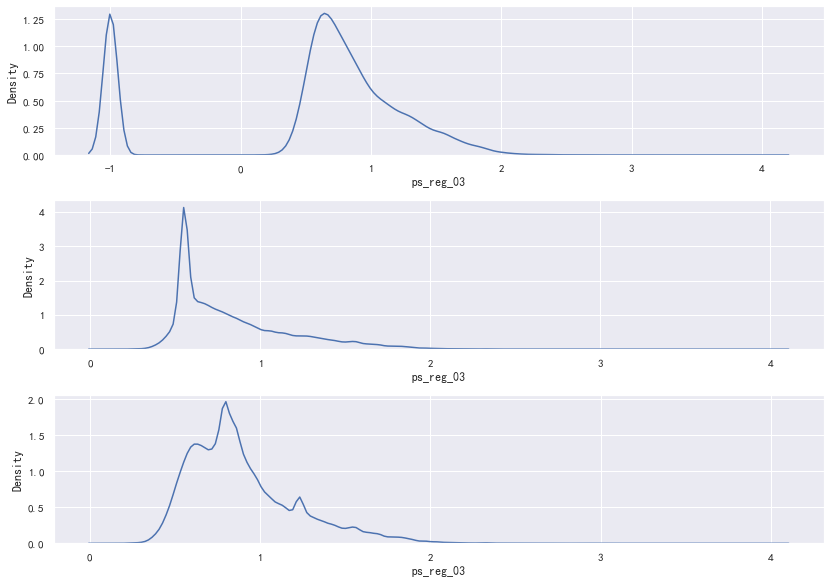

In [21]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[0]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[0]].replace(-1,np.nan).fillna(train[set3[0]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[0]])

plt.tight_layout()

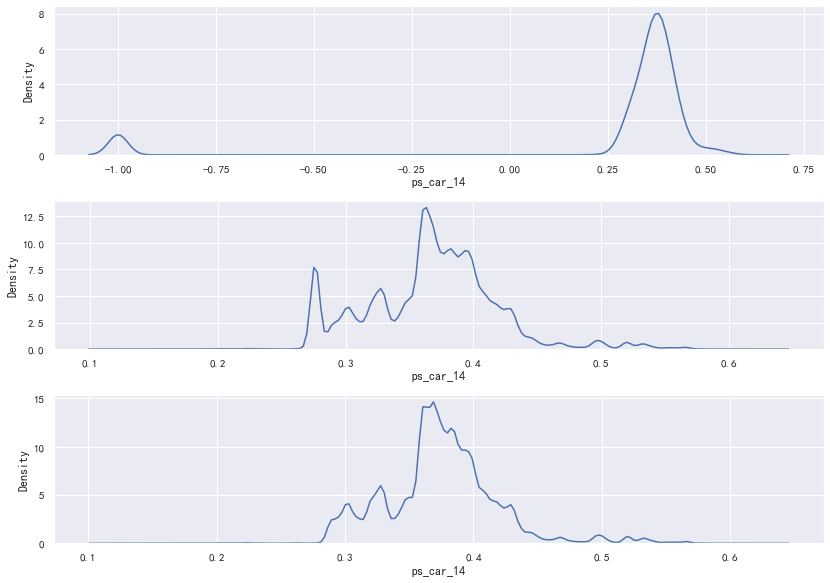

In [22]:
plt.subplot(3,1,1)
sns.kdeplot(train[set3[1]])
plt.subplot(3,1,2)
sns.kdeplot(train[set3[1]].replace(-1,np.nan).fillna(train[set3[1]].mean()))
plt.subplot(3,1,3)
sns.kdeplot(pd.DataFrame(set3_imp,columns = set3)[set3[1]])

plt.tight_layout()

It can be seen that MICE can better fit the probability distribution of the original variable, so we choose to use MICE filling.

In [24]:
train[set3] = pd.DataFrame(set3_imp,columns = set3)

In [25]:
from sklearn.impute import SimpleImputer

In [26]:
mode_imputer = SimpleImputer(missing_values = -1, strategy='most_frequent',add_indicator=True)

In [27]:
missing_data[4:]

,missing,missing_percent,imputation
colname,,,
ps_car_07_cat,28820,28820(1.94%),mode
ps_ind_05_cat,14519,14519(0.98%),mode
ps_car_09_cat,1446,1446(0.1%),mode
ps_ind_02_cat,523,523(0.04%),mode
ps_car_01_cat,267,267(0.02%),mode
ps_ind_04_cat,228,228(0.02%),mode
ps_car_02_cat,10,10(0.0%),mode
ps_car_11,6,6(0.0%),"(mode, median)"
ps_car_12,1,1(0.0%),"(mode, median, mean)"


In [28]:
imp = mode_imputer.fit_transform(train[missing_data[4:].index])

In [29]:
train[missing_data[4:].index]=pd.DataFrame(imp).iloc[:,:len(missing_data[4:].index)]

In [30]:
train[missing_data[4:].index] = train[missing_data[4:].index].astype('int64')

In [31]:
# drop columns
train.drop(cols_to_drop,axis=1,inplace=True)

In [32]:
# check out if we still have -1 
(train == -1).sum().sum()

0

In [41]:
train.to_csv('train_imp.csv')